In [6]:
import xarray as xr
import numpy as np
from scipy.special import lambertw

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from numba import vectorize
import logging

import geopandas
from shapely.geometry import Polygon

In [7]:
# Set the logging level to WARNING
logging.basicConfig(level=logging.ERROR)

In [8]:
@vectorize(nopython=True, cache=True)
def wbpt(p, T):
    """
    Computes the wet-bulb potential temperature (WBPT) thw of the
    pseudoadiabat that passes through pressure p and temperature T.

    Uses polynomial approximations from Moisseeva and Stull (2017)
    with revised coefficients.

    Moisseeva, N. and Stull, R., 2017. A noniterative approach to
        modelling moist thermodynamics. Atmospheric Chemistry and
        Physics, 17, 15037-15043.

    Args:
        p: pressure (Pa)
        T: temperature (K)

    Returns:
        thw: wet-bulb potential temperature (K)

    """

    # Convert p to hPa and T to degC
    p_ = p / 100.
    T_ = T - 273.15

    # Check that values fall in the permitted range
    if (T_ < -100.) or (T_ > 50.) or (p_ > 1100.) or (p_ < 50.):
        # print('T or p outside limits of polynomial fit', T_, p_)
        return np.nan

    # Compute theta-w using Eq. 4-6 from Moisseeva & Stull 2017
    Tref = 5.480079558912395754e+01 + p_*(-5.702912372295836363e-01 + p_*(6.214635352625029474e-03 + p_*(-6.634002758531432769e-05 + p_*(4.775890354003946154e-07 + p_*(-2.284857526370373519e-09 + p_*(6.641586128297075239e-12 + p_*(-7.712521760947926640e-15 + p_*(-2.044872914238500011e-17 + p_*(1.120406966307735934e-19 + p_*(-2.393726252696363534e-22 + p_*(2.666858658235125377e-25 + p_*(-8.684116177147550627e-29 + p_*(-1.672712626829787198e-31 + p_*(2.183518619078883688e-34 + p_*(-1.547439304626812778e-38 + p_*(-1.937257327731052786e-40 + p_*(2.161580416088237645e-43 + p_*(-1.160157488827817865e-46 + p_*(3.277570207101446812e-50 + p_*(-3.923759467350554795e-54))))))))))))))))))))  # noqa: E501
    thw = 4.232924249278688222e+01 + T_*(5.718008668788681081e-01 + T_*(6.676735845163824824e-03 + T_*(4.022733506471462767e-05 + T_*(-9.509825840570524462e-07 + T_*(-7.879928387880090530e-09 + T_*(1.767656648682178749e-10 + T_*(2.337360533109320417e-12 + T_*(-3.564315751634256907e-14 + T_*(-6.615642909573364126e-16 + T_*(5.465028726086066100e-18 + T_*(1.710624575834384904e-19 + T_*(-1.714074684770886933e-22 + T_*(-3.374318285502554966e-23 + T_*(-1.906956286638301820e-25 + T_*(3.748889164551010026e-27 + T_*(4.895600997189238897e-29 + T_*(-3.555428293757981745e-32 + T_*(-3.897220799151443075e-33 + T_*(-2.551411607182840165e-35 + T_*(-5.417589606240612172e-38)))))))))))))))))))) + Tref*(3.623240553023549526e-01 + T_*(1.023375828905026411e-03 + T_*(7.652197539188903771e-05 + T_*(-3.335127874231546565e-07 + T_*(-1.156314790854086800e-08 + T_*(5.997724820856132307e-11 + T_*(3.205744785514147323e-12 + T_*(-3.725255127402225228e-15 + T_*(-4.985713597883638890e-16 + T_*(-1.788582915460586641e-17 + T_*(8.672108280207142462e-20 + T_*(1.195118892414961522e-20 + T_*(-3.811303263205360248e-24 + T_*(-3.991925996145037697e-24 + T_*(-1.495975110164947026e-26 + T_*(6.968870338282429091e-28 + T_*(6.209536671787076346e-30 + T_*(-3.566388507077176018e-32 + T_*(-7.450360218688953006e-34 + T_*(-3.816398138670827989e-36 + T_*(-6.712873080670899696e-39)))))))))))))))))))) + Tref*(2.901968635714725214e-03 + T_*(6.487857234220085253e-05 + T_*(7.743602693621120145e-07 + T_*(-9.204198773051246169e-09 + T_*(-2.122032402927605809e-10 + T_*(4.125625669666862445e-12 + T_*(3.532509087599244118e-14 + T_*(-5.242786376794922436e-16 + T_*(-7.260942673196442122e-18 + T_*(-2.453561164912172901e-19 + T_*(5.678598204071161723e-21 + T_*(1.229928951189520298e-22 + T_*(-2.566095852346387466e-24 + T_*(-2.594462117958716581e-26 + T_*(6.198016439919091221e-28 + T_*(4.079274536668629507e-30 + T_*(-8.523972978819286856e-32 + T_*(-6.333007168641729819e-34 + T_*(4.884637765078024090e-36 + T_*(5.970619077275256973e-38 + T_*(1.583552627627211185e-40)))))))))))))))))))) + Tref*(6.709096824546971884e-05 + T_*(1.164430354507516326e-06 + T_*(1.492519185739810694e-08 + T_*(-1.004992535578806199e-10 + T_*(-5.194638284127568879e-12 + T_*(-8.852593174458557238e-14 + T_*(7.743098463983663378e-15 + T_*(-1.349430816115996717e-17 + T_*(-5.111520085301861189e-18 + T_*(7.246506699900768993e-20 + T_*(1.688571447195582101e-21 + T_*(-4.458601255074950933e-23 + T_*(-3.906571883790175152e-25 + T_*(1.401012855147709264e-26 + T_*(1.049655774799796372e-28 + T_*(-2.326684433917799696e-30 + T_*(-2.546715297351952591e-32 + T_*(1.076294752796537571e-34 + T_*(2.697444862568323708e-36 + T_*(1.404413350272535558e-38 + T_*(2.444355701979738372e-41)))))))))))))))))))) + Tref*(5.609138211497678676e-07 + T_*(2.619248932484586790e-08 + T_*(1.268762007103502264e-10 + T_*(-1.010471605550804941e-12 + T_*(-1.709919997846759906e-13 + T_*(-9.956527977396212394e-16 + T_*(2.437200472916002895e-16 + T_*(-2.053684743415526158e-18 + T_*(-1.347065496266485984e-19 + T_*(2.110916506052379395e-21 + T_*(3.809682178285610452e-23 + T_*(-7.906486212697025412e-25 + T_*(-6.716781189658700860e-27 + T_*(1.545503563949260188e-28 + T_*(8.638277498899926506e-31 + T_*(-1.671970193463004779e-32 + T_*(-7.800495852299937013e-35 + T_*(9.773608301957742171e-37 + T_*(3.864485572169008074e-39 + T_*(-3.451329681590587444e-41 + T_*(-1.629936596105260491e-43)))))))))))))))))))) + Tref*(6.211050901462248372e-09 + T_*(3.874480667788168084e-10 + T_*(4.106851040300304659e-12 + T_*(-3.105169520741854561e-13 + T_*(6.522151398403065119e-16 + T_*(3.096283820459271858e-16 + T_*(-6.565926448866785715e-18 + T_*(-7.159450456455795076e-20 + T_*(4.894802418930987747e-21 + T_*(-6.001966927419548388e-23 + T_*(-1.513821153252045092e-24 + T_*(5.010070342130555091e-26 + T_*(3.162510217391503999e-28 + T_*(-1.770123180458273006e-29 + T_*(-1.053932297446173471e-31 + T_*(3.190827677655366054e-33 + T_*(3.180222107117949408e-35 + T_*(-1.648380290063498673e-37 + T_*(-3.706141650512771631e-39 + T_*(-1.917722264772635693e-41 + T_*(-3.362382426227650908e-44)))))))))))))))))))) + Tref*(1.263124849842055366e-10 + T_*(6.187412516523896449e-12 + T_*(4.856354852070540130e-14 + T_*(-9.099759444145425678e-15 + T_*(1.560190728375411453e-16 + T_*(7.844891934613453307e-18 + T_*(-3.045057457877816053e-19 + T_*(-2.301735187073350059e-22 + T_*(1.799768784739026120e-22 + T_*(-2.234656647103105002e-24 + T_*(-5.049062278648236422e-26 + T_*(1.234519814239864004e-27 + T_*(8.987122286706115913e-30 + T_*(-3.505893794831842691e-31 + T_*(-1.936267714478340583e-33 + T_*(5.615005967424700712e-35 + T_*(4.748626410980998077e-37 + T_*(-3.117187102765338827e-39 + T_*(-5.342048836982600040e-41 + T_*(-2.315823054010398044e-43 + T_*(-3.233422625384509680e-46)))))))))))))))))))) + Tref*(3.041933860088385168e-12 + T_*(7.093111999258697384e-14 + T_*(-1.844005764063040847e-15 + T_*(-3.012726184142518609e-18 + T_*(2.286804695745121757e-18 + T_*(-3.778946134964007883e-20 + T_*(-5.425688203547919150e-22 + T_*(1.720852091689116264e-23 + T_*(-2.132216029860537651e-25 + T_*(1.204097053514651607e-26 + T_*(9.674019166203633406e-29 + T_*(-1.310039385511127070e-29 + T_*(-3.441825993234164085e-32 + T_*(5.218559560287548561e-33 + T_*(2.792178449174765620e-35 + T_*(-9.909642936552052681e-37 + T_*(-1.027812531335395456e-38 + T_*(4.888180488713776030e-41 + T_*(1.228573493776009552e-42 + T_*(6.780669148124561191e-45 + T_*(1.273888703944060394e-47)))))))))))))))))))) + Tref*(4.269738908941117406e-14 + T_*(3.515691990558187008e-16 + T_*(-5.752406629775988591e-17 + T_*(2.935526497578685499e-18 + T_*(-1.396603096459919851e-20 + T_*(-3.076116403302916373e-21 + T_*(9.652802795654607107e-23 + T_*(9.479133640033158372e-26 + T_*(-6.298473009854447451e-26 + T_*(1.067398063166126933e-27 + T_*(1.747803610841354067e-29 + T_*(-6.553290148516108139e-31 + T_*(-3.304812034827328800e-33 + T_*(2.060835499621757621e-34 + T_*(1.070192724105747808e-36 + T_*(-3.514326016203337634e-38 + T_*(-3.229557610146469936e-40 + T_*(1.843938327239782823e-42 + T_*(3.752745971817626646e-44 + T_*(1.855294075718714751e-46 + T_*(3.111545317890359977e-49)))))))))))))))))))) + Tref*(3.187227602061177940e-16 + T_*(-1.653226486329436251e-18 + T_*(-5.503279650803687541e-19 + T_*(3.910889420859907195e-20 + T_*(-4.933223004188857164e-22 + T_*(-3.385127545168397706e-23 + T_*(1.323951437519895638e-24 + T_*(-2.175849457167253713e-27 + T_*(-7.767216266915100570e-28 + T_*(1.278597695041199424e-29 + T_*(2.085697980946302978e-31 + T_*(-6.977592433892922353e-33 + T_*(-3.774593366845591632e-35 + T_*(2.047178660783037856e-36 + T_*(1.050350400037973286e-38 + T_*(-3.355921373609339394e-40 + T_*(-2.957951585520604123e-42 + T_*(1.782466345297969279e-44 + T_*(3.384503662089840092e-46 + T_*(1.597754239120040422e-48 + T_*(2.533589690591361309e-51)))))))))))))))))))) + Tref*(9.638094015677524082e-19 + T_*(-1.825497478946932691e-20 + T_*(-1.687807799941253959e-21 + T_*(1.540362530250114278e-22 + T_*(-2.627978436697326027e-24 + T_*(-1.158894467996326174e-25 + T_*(5.277085797941572453e-27 + T_*(-1.725975868117368293e-29 + T_*(-2.913361578529600527e-30 + T_*(4.827457622910831529e-32 + T_*(7.681289388780240843e-34 + T_*(-2.437302887117087984e-35 + T_*(-1.370426782411350938e-37 + T_*(6.806940090614902811e-39 + T_*(3.495435520132081072e-41 + T_*(-1.081253869553308734e-42 + T_*(-9.298263251666167061e-45 + T_*(5.750522446000603233e-47 + T_*(1.045544411570244632e-48 + T_*(4.767127037305669495e-51 + T_*(7.211593011699459480e-54))))))))))))))))))))))))))))))  # noqa: E501

    # Return theta-w converted to K
    return thw + 273.15


@vectorize(nopython=True, cache=True)
def temp(p, thw):
    """
    Computes the temperature T at pressure p on a pseudoadiabat with
    wet-bulb potential temperature thw.

    Uses polynomial approximations from Moisseeva and Stull (2017) with
    revised coefficients.

    Moisseeva, N. and Stull, R., 2017. A noniterative approach to
        modelling moist thermodynamics. Atmospheric Chemistry and
        Physics, 17, 15037-15043.

    Args:
        p: pressure (Pa)
        thw: wet-bulb potential temperature (K)

    Returns:
        T: temperature (K)

    """

    # Convert p to hPa and theta-w to degC
    p_ = p / 100.
    thw_ = thw - 273.15

    # Check that values fall in the permitted range
    if (thw_ < -70.) or (thw_ > 50.) or (p_ > 1100.) or (p_ < 50.):
        # print('thw or p outside limits of polynomial fit', thw_, p_)
        return np.nan

    # Compute T using Eq. 1-3 from Moisseeva & Stull 2017
    thref = -1.958881611671661176e+02 + p_*(2.134884082821395079e+00 + p_*(-2.651475098307509368e-02 + p_*(2.861864119262733791e-04 + p_*(-2.298718394514268143e-06 + p_*(1.360057184923542422e-08 + p_*(-5.958196441636455271e-11 + p_*(1.938675375399162892e-13 + p_*(-4.665355621127693766e-16 + p_*(8.139597343471045903e-19 + p_*(-9.718027816571788133e-22 + p_*(6.514043622263483823e-25 + p_*(4.795894401108516600e-29 + p_*(-5.561331861642867047e-31 + p_*(4.256943236052971359e-34 + p_*(1.115187417957733097e-37 + p_*(-4.675607928134105329e-40 + p_*(4.189061674074321886e-43 + p_*(-1.989920659873727387e-46 + p_*(5.148437033814795851e-50 + p_*(-5.751272231517078191e-54))))))))))))))))))))  # noqa: E501
    T = -2.899089457107268331e+01 + thw_*(1.337227498242554491e+00 + thw_*(9.989220649709655911e-03 + thw_*(-5.289649585393284086e-05 + thw_*(-8.125516739581656903e-06 + thw_*(-1.669385809901756079e-07 + thw_*(3.902176729685648592e-09 + thw_*(2.785299448741561866e-10 + thw_*(1.199597501486574654e-12 + thw_*(-2.356495994204141054e-13 + thw_*(-3.754462622941184458e-15 + thw_*(1.109955443870932428e-16 + thw_*(2.958323602057082693e-18 + thw_*(-2.247001341245910925e-20 + thw_*(-1.185942142170470679e-21 + thw_*(-2.645697164120065566e-24 + thw_*(2.354624142321289223e-25 + thw_*(2.070711502559931296e-27 + thw_*(-1.458747561161565743e-29 + thw_*(-2.729648310305078289e-31 + thw_*(-1.030941535866486469e-33)))))))))))))))))))) + thref*(1.429869503550506904e+00 + thw_*(-7.879837833208863662e-03 + thw_*(-6.838366952421416926e-04 + thw_*(-1.598425851503747948e-05 + thw_*(2.249449259819928238e-07 + thw_*(3.397632056104877195e-08 + thw_*(7.042819999431954275e-10 + thw_*(-3.396305216284396052e-11 + thw_*(-1.427634441882554734e-12 + thw_*(1.718717725756761431e-14 + thw_*(1.351301204465966675e-15 + thw_*(-6.192018154861673091e-19 + thw_*(-7.436786948388566283e-19 + thw_*(-4.586031806307956854e-21 + thw_*(2.361621265751940082e-22 + thw_*(2.687010240026768440e-24 + thw_*(-3.700784758878172927e-26 + thw_*(-6.641106252235517576e-28 + thw_*(9.656001298499274765e-31 + thw_*(6.328645165577936637e-32 + thw_*(2.937789149798092732e-34)))))))))))))))))))) + thref*(5.040685977297330346e-03 + thw_*(-5.183478788794109284e-04 + thw_*(-8.614096880135471002e-06 + thw_*(6.838202302696602762e-07 + thw_*(4.744824589422048218e-08 + thw_*(4.117928705641196483e-10 + thw_*(-8.162969260401781373e-11 + thw_*(-2.506138383042399551e-12 + thw_*(6.408005845436154616e-14 + thw_*(3.422786758033482118e-15 + thw_*(-1.423870299706560812e-17 + thw_*(-2.347455893945982803e-18 + thw_*(-1.318085039469029337e-20 + thw_*(8.499042116124600158e-22 + thw_*(1.076807733584116111e-23 + thw_*(-1.338371226030613206e-25 + thw_*(-3.037207845698305137e-27 + thw_*(-2.280138198346503550e-30 + thw_*(2.951988306149798322e-31 + thw_*(2.237589772936888619e-33 + thw_*(4.618048611010569571e-36)))))))))))))))))))) + thref*(-1.693011573882441043e-04 + thw_*(-4.055505851887614839e-06 + thw_*(7.152523677763036439e-07 + thw_*(3.843257858703898518e-08 + thw_*(-5.844911310861310370e-10 + thw_*(-1.223121149866247755e-10 + thw_*(-1.922842158181238273e-12 + thw_*(1.860182907731545371e-13 + thw_*(5.585246327323852151e-15 + thw_*(-1.464431913286146844e-16 + thw_*(-6.559251795406730752e-18 + thw_*(4.899420092423094807e-20 + thw_*(4.199638168089739444e-21 + thw_*(7.896679384714861248e-24 + thw_*(-1.500870337486252050e-24 + thw_*(-1.219254495390460205e-26 + thw_*(2.649010861349269856e-28 + thw_*(3.763581851733364165e-30 + thw_*(-1.106962190807747265e-32 + thw_*(-4.004411643912248489e-34 + thw_*(-1.755651685348803267e-36)))))))))))))))))))) + thref*(-3.362873566158531171e-06 + thw_*(2.400942971282232631e-07 + thw_*(2.216103471465453210e-08 + thw_*(-2.358530382561856690e-10 + thw_*(-9.126436748430261388e-11 + thw_*(-1.931576827275146865e-12 + thw_*(1.740569037403095845e-13 + thw_*(6.367717531052867911e-15 + thw_*(-1.593228821759510933e-16 + thw_*(-8.645773823963254084e-18 + thw_*(5.183005959622386943e-20 + thw_*(6.216660172191152019e-21 + thw_*(2.280562673183416492e-23 + thw_*(-2.407055696000981067e-24 + thw_*(-2.497159694469028016e-26 + thw_*(4.310619140953843283e-28 + thw_*(7.767424624269287546e-30 + thw_*(-8.253668170995669652e-33 + thw_*(-8.265671014355856887e-34 + thw_*(-5.055332555603654578e-36 + thw_*(-6.866406703219498400e-39)))))))))))))))))))) + thref*(3.313006618121957636e-08 + thw_*(6.298294495254139702e-09 + thw_*(-1.508115170726802090e-10 + thw_*(-3.666058876697772524e-11 + thw_*(-6.929713447725405319e-13 + thw_*(1.001411867284538917e-13 + thw_*(3.999009200007800670e-15 + thw_*(-1.355140171228429127e-16 + thw_*(-7.891853868577618701e-18 + thw_*(8.201739075969596332e-20 + thw_*(8.157502196248929472e-21 + thw_*(1.872664694326145830e-24 + thw_*(-4.816139246993863831e-24 + thw_*(-3.251690295448622985e-26 + thw_*(1.596069969864303561e-27 + thw_*(1.911924811476329357e-29 + thw_*(-2.539650134731972660e-31 + thw_*(-4.766708118214056693e-33 + thw_*(5.905961735438100206e-36 + thw_*(4.542824189463173739e-37 + thw_*(2.146594442973875009e-39)))))))))))))))))))) + thref*(1.827646537676912968e-09 + thw_*(2.700624495348298076e-11 + thw_*(-1.693998063665866103e-11 + thw_*(-6.246467298925717754e-13 + thw_*(5.645404365776630832e-14 + thw_*(3.192962277411950210e-15 + thw_*(-8.101287993813953261e-17 + thw_*(-7.067390583742533053e-18 + thw_*(2.929925634625895208e-20 + thw_*(8.199180601829400231e-21 + thw_*(5.440328877403649776e-23 + thw_*(-5.211512128625378953e-24 + thw_*(-7.469192185405930370e-26 + thw_*(1.680194632500845717e-27 + thw_*(3.931613027193546259e-29 + thw_*(-1.570489589795977390e-31 + thw_*(-9.529584442335513237e-33 + thw_*(-4.564784845461340239e-35 + thw_*(7.845559059350718099e-37 + thw_*(9.429015911623818610e-39 + thw_*(2.969487264396173626e-41)))))))))))))))))))) + thref*(2.692489627401177037e-11 + thw_*(-8.866612549898191130e-13 + thw_*(-3.282133330510417204e-13 + thw_*(-2.176991467782678476e-15 + thw_*(1.525548282484946781e-15 + thw_*(3.255140898734812961e-17 + thw_*(-3.448238972506286259e-18 + thw_*(-9.819269470584681398e-20 + thw_*(4.103973882000636586e-21 + thw_*(1.421360768154288777e-22 + thw_*(-2.535930235573404443e-24 + thw_*(-1.138555920321440711e-25 + thw_*(6.357268121704545670e-28 + thw_*(5.168500299704030730e-29 + thw_*(8.966189300449154540e-32 + thw_*(-1.256207628001013337e-32 + thw_*(-8.343615181202799912e-35 + thw_*(1.324806169302695400e-36 + thw_*(1.409632581667273272e-38 + thw_*(-1.806982775263108798e-41 + thw_*(-4.102485528397047362e-43)))))))))))))))))))) + thref*(2.012525693579932692e-13 + thw_*(-1.409558681656955683e-14 + thw_*(-3.000478150434391517e-15 + thw_*(3.523413088054992200e-17 + thw_*(1.627592243174956061e-17 + thw_*(1.005263036983865846e-19 + thw_*(-4.256579318654112554e-20 + thw_*(-5.804877230475824782e-22 + thw_*(5.995951096343076474e-23 + thw_*(1.084604700494159426e-24 + thw_*(-4.758795393781846959e-26 + thw_*(-1.049404375984382912e-27 + thw_*(2.091294597612180069e-29 + thw_*(5.744517949902291411e-31 + thw_*(-4.386198422439627512e-33 + thw_*(-1.770452206683057335e-34 + thw_*(9.429173370089740969e-38 + thw_*(2.809453846841474016e-38 + thw_*(1.073364281318929982e-40 + thw_*(-1.723453344911116331e-42 + thw_*(-1.112769846261706298e-44)))))))))))))))))))) + thref*(7.785302726588919706e-16 + thw_*(-8.115422322369204709e-17 + thw_*(-1.359423616814330821e-17 + thw_*(3.494943093543307934e-19 + thw_*(8.118345806601954328e-20 + thw_*(-3.050691842782283411e-22 + thw_*(-2.304670197233203703e-22 + thw_*(-1.264239996599368699e-24 + thw_*(3.525780381700034179e-25 + thw_*(3.805080939256278211e-27 + thw_*(-3.081460621592729418e-28 + thw_*(-4.551988505380969105e-30 + thw_*(1.546975182182166271e-31 + thw_*(2.902341615631649949e-33 + thw_*(-4.149081096195920384e-35 + thw_*(-1.029080159047627957e-36 + thw_*(4.190976007612783375e-39 + thw_*(1.906088654394316995e-40 + thw_*(3.603634349189407222e-43 + thw_*(-1.430304392526457524e-44 + thw_*(-8.040338359871879916e-47)))))))))))))))))))) + thref*(1.239375080712697757e-18 + thw_*(-1.697253721082437881e-19 + thw_*(-2.457949980434437093e-20 + thw_*(9.128133448732742170e-22 + thw_*(1.568961363107645293e-22 + thw_*(-1.757664150666109165e-24 + thw_*(-4.703796383698215715e-25 + thw_*(2.947044230184508861e-29 + thw_*(7.581119354391254214e-28 + thw_*(4.806360277319273094e-30 + thw_*(-7.004664901833034528e-31 + thw_*(-7.627496323163632015e-33 + thw_*(3.757741880027517288e-34 + thw_*(5.601780195611557017e-36 + thw_*(-1.108150827912297810e-37 + thw_*(-2.199929486827426309e-39 + thw_*(1.405470896802169264e-41 + thw_*(4.459709728573167858e-43 + thw_*(3.991616449307566712e-46 + thw_*(-3.666103046079535075e-47 + thw_*(-1.943440793139680257e-49))))))))))))))))))))))))))))))  # noqa: E501

    # Return T converted to K
    return T + 273.15

In [9]:
# Acceleration due to gravity (m/s2)
g = 9.81

# Specific gas constant for dry air (J/kg/K)
Rd = 287.0

# Specific gas constant for water vapour (J/kg/K)
Rv = 461.5

# Ratio of gas constants for dry air and water vapour
eps = Rd / Rv

# Isobaric specific heat of dry air (J/kg/K)
cpd = 1005.0

# Isobaric specific heat of water vapour (J/kg/K)
cpv = 2040.0  # optimised value from Ambaum (2020)

# Isobaric specific heat of liquid water (J/kg/K)
cpl = 4220.0  # triple-point value from Wagner and Pruß (2002)

# Isobaric specific heat of ice (J/kg/K)
cpi = 2097.0  # triple-point value from Feistel and Wagner (2006)

# Reference pressure (Pa)
p_ref = 1.0e5

# Triple point temperature (K)
T0 = 273.16

# Saturation vapour pressure at the triple point (Pa)
es0 = 611.657  # Guildner et al. (1976)

# Latent heat of vaporisation at the triple point (J/kg)
Lv0 = 2.501e6  # Wagner and Pruß (2002)

# Latent heat of freezing at the triple point (J/kg)
Lf0 = 0.333e6  # Feistel and Wagner (2006)

# Latent heat of sublimation at the triple point (J/kg)
Ls0 = Lv0 + Lf0  

# Temperature above which all condensate is assumed to be liquid (K)
T_liq = 273.15  

# Temperature below which all condensate is assumed to be ice (K)
T_ice = 253.15

In [10]:

# Precision for iterative temperature calculations (K)
precision = 0.001

# Maximum number of iterations for iterative calculations
max_n_iter = 20


def effective_gas_constant(q, qt=None):
    """
    Computes effective gas constant for moist air.

    Args:
        q (float or ndarray): specific humidity (kg/kg)
        qt (float or ndarray, optional): total water mass fraction (kg/kg)
            (default is None, which implies qt = q)

    Returns:
        Rm (float or ndarray): effective gas constant (J/kg/K)

    """
    if qt is None:
        Rm = (1 - q) * Rd + q * Rv
    else:
        Rm = (1 - qt) * Rd + q * Rv

    return Rm


def effective_specific_heat(q, qt=None, omega=0.0):
    """
    Computes effective isobaric specific heat for moist air.

    Args:
        q (float or ndarray): specific humidity (kg/kg)
        qt (float or ndarray, optional): total water mass fraction (kg/kg)
            (default is None, which implies qt = q)
        omega (float or ndarray, optional): ice fraction

    Returns:
        cpm (float or ndarray): effective isobaric specific heat (J/kg/K)

    """
    if qt is None:
        cpm = (1 - q) * cpd + q * cpv
    else:
        ql = (1 - omega) * (qt - q)  # liquid water mass fraction
        qi = omega * (qt - q)        # ice water mass fraction
        cpm = (1 - qt) * cpd + q * cpv + ql * cpl + qi * cpi

    return cpm


def latent_heat_of_vaporisation(T):
    """
    Computes latent heat of vaporisation for a given temperature.

    Args:
        T (float or ndarray): temperature (K)

    Returns:
        Lv (float or ndarray): latent heat of vaporisation (J/kg)

    """
    Lv = Lv0 + (cpv - cpl) * (T - T0)

    return Lv


def latent_heat_of_freezing(T):
    """
    Computes latent heat of freezing for a given temperature.

    Args:
        T (float or ndarray): temperature (K)

    Returns:
        Lf (float or ndarray): latent heat of freezing (J/kg)

    """
    Lf = Lf0 + (cpl - cpi) * (T - T0)

    return Lf


def latent_heat_of_sublimation(T):
    """
    Computes latent heat of sublimation for a given temperature.

    Args:
        T (float or ndarray): temperature (K)

    Returns:
        Ls (float or ndarray): latent heat of sublimation (J/kg)

    """
    Ls = Ls0 + (cpv - cpi) * (T - T0)

    return Ls


def mixed_phase_latent_heat(T, omega):
    """
    Computes mixed-phase latent heat for a given temperature and ice fraction.

    Args:
        T (float or ndarray): temperature (K)
        omega (float or ndarray): ice fraction

    Returns:
        Ls (float or ndarray): latent heat of sublimation (J/kg)

    """
    cpx = (1 - omega) * cpl + omega * cpi
    Lx0 = (1 - omega) * Lv0 + omega * Ls0  # = Lv0 + omega * Lf0
    Lx = Lx0 + (cpv - cpx) * (T - T0)  # = (1 - omega) * Lv + omega * Ls
                                       # = Lv + omega * Lf

    return Lx


def air_density(p, T, q, qt=None):
    """
    Computes density of air using the ideal gas equation.

    Args:
        p (float or ndarray): pressure (Pa)
        T (float or ndarray): temperature (K)
        q (float or ndarray): specific humidity (kg/kg)
        qt (float or ndarray, optional): total water mass fraction (kg/kg)
            (default is None, which implies qt = q)

    Returns:
        rho (float or ndarray): air density (kg/m3)

    """
    Rm = effective_gas_constant(q, qt=qt)
    rho = p / (Rm * T)

    return rho


def dry_air_density(p, T, q, qt=None):
    """
    Computes density of dry air using the ideal gas equation.

    Args:
        p (float or ndarray): pressure (Pa)
        T (float or ndarray): temperature (K)
        q (float or ndarray): specific humidity (kg/kg)
        qt (float or ndarray, optional): total water mass fraction (kg/kg)
            (default is None, which implies qt = q)

    Returns:
        rhod (float or ndarray): dry air density (kg/m3)

    """
    rho = air_density(p, T, q, qt=qt)
    if qt is None:
        rhod = (1 - q) * rho
    else:
        rhod = (1 - qt) * rho

    return rhod


def virtual_temperature(T, q, qt=None):
    """
    Computes virtual (or density) temperature.

    Args:
        T (float or ndarray): temperature (K)
        q (float or ndarray): specific humidity (kg/kg)
        qt (float or ndarray, optional): total water mass fraction (kg/kg)
            (default is None, which implies qt = q)

    Returns:
        Tv (float or ndarray): virtual (or density) temperature (K)

    """
    if qt is None:
        Tv = T * (1 - q + q / eps)  # virtual temperature
    else:
        Tv = T * (1 - qt + q / eps)  # density temperature

    return Tv


def mixing_ratio(q, qt=None):
    """
    Computes mixing ratio from specific humidity.

    Args:
        q (float or ndarray): specific humidity (kg/kg)
        qt (float or ndarray, optional): total water mass fraction (kg/kg)
            (default is None, which implies qt = q)

    Returns:
        r (float or ndarray): mixing ratio (kg/kg)

    """
    if qt is None:
        r = q / (1 - q)
    else:
        r = q / (1 - qt)

    return r


def vapour_pressure(p, q, qt=None):
    """
    Computes vapour pressure from pressure and specific humidity.

    Args:
        p (float or ndarray): pressure (Pa)
        q (float or ndarray): specific humidity (kg/kg)
        qt (float or ndarray, optional): total water mass fraction (kg/kg)
            (default is None, which implies qt = q)

    Returns:
        e (float or ndarray): vapour pressure (Pa)

    """
    if qt is None:
        e = p * q / (eps * (1 - q) + q)
    else:
        e = p * q / (eps * (1 - qt) + q)

    return e


def saturation_vapour_pressure(T, phase='liquid', omega=0.0):
    """
    Computes saturation vapour pressure (SVP) for a given temperature using
    equations from Ambaum (2020).

    Args:
        T (float or ndarray): temperature (K)
        phase (str, optional): condensed water phase (valid options are
            'liquid', 'ice', or 'mixed'; default is 'liquid')
        omega (float or ndarray, optional): ice fraction at saturation
            (default is 0.0)

    Returns:
        es (float or ndarray): saturation vapour pressure (Pa)

    """
   
    if phase == 'liquid':
        
        # Compute latent heat of vaporisation
        Lv = latent_heat_of_vaporisation(T)

        # Compute SVP over liquid water (Ambaum 2020, Eq. 13)
        es = es0 * np.power((T0 / T), ((cpl - cpv) / Rv)) * \
            np.exp((Lv0 / (Rv * T0)) - (Lv / (Rv * T)))
        
    elif phase == 'ice':
        
        # Compute latent heat of sublimation
        Ls = latent_heat_of_sublimation(T)

        # Compute SVP over ice (Ambaum 2020, Eq. 17)
        es = es0 * np.power((T0 / T), ((cpi - cpv) / Rv)) * \
            np.exp((Ls0 / (Rv * T0)) - (Ls / (Rv * T)))
        
    elif phase == 'mixed':
        
        # Compute mixed-phase specific heat
        cpx = (1 - omega) * cpl + omega * cpi
        
        # Compute mixed-phase latent heat at the triple point
        Lx0 = (1 - omega) * Lv0 + omega * Ls0

        # Compute mixed-phase latent heat
        Lx = Lx0 - (cpx - cpv) * (T - T0)
        
        # Compute mixed-phase SVP
        es = es0 * np.power((T0 / T), ((cpx - cpv) / Rv)) * \
            np.exp((Lx0 / (Rv * T0)) - (Lx / (Rv * T)))
        
    else:

        raise ValueError("phase must be one of 'liquid', 'ice', or 'mixed'")

    return es


def saturation_specific_humidity(p, T, qt=None, phase='liquid', omega=0.0):
    """
    Computes saturation specific humidity from pressure and temperature.

    Args:
        p (float or ndarray): pressure (Pa)
        T (float or ndarray): temperature (K)
        qt (float or ndarray, optional): total water mass fraction (kg/kg)
            (default is None, which implies qt = q)
        phase (str, optional): condensed water phase (valid options are
            'liquid', 'ice', or 'mixed'; default is 'liquid')
        omega (float or ndarray, optional): ice fraction at saturation
            (default is 0.0)

    Returns:
        qs (float or ndarray): saturation specific humidity (kg/kg)

    """
    es = saturation_vapour_pressure(T, phase=phase, omega=omega)
    if qt is None:
        qs = eps * es / (p - (1 - eps) * es)
    else:
        qs  = (1 - qt) * eps * es / (p - es)

    return qs


def saturation_mixing_ratio(p, T, phase='liquid', omega=0.0):
    """
    Computes saturation mixing ratio from pressure and temperature.

    Args:
        p (float or ndarray): pressure (Pa)
        T (float or ndarray): temperature (K)
        phase (str, optional): condensed water phase (valid options are
            'liquid', 'ice', or 'mixed'; default is 'liquid')
        omega (float or ndarray, optional): ice fraction at saturation
            (default is 0.0)

    Returns:
        rs (float or ndarray): saturation mixing ratio (kg/kg)

    """
    es = saturation_vapour_pressure(T, phase=phase, omega=omega)
    rs = eps * es / (p - es)

    return rs


def relative_humidity(p, T, q, qt=None, phase='liquid', omega=0.0):
    """
    Computes relative humidity with respect to specified phase from pressure, 
    temperature, and specific humidity.

    Args:
        p (float or ndarray): pressure (Pa)
        T (float or ndarray): temperature (K)
        q (float or ndarray): specific humidity (kg/kg)
        qt (float or ndarray, optional): total water mass fraction (kg/kg)
            (default is None, which implies qt = q)
        phase (str, optional): condensed water phase (valid options are
            'liquid', 'ice', or 'mixed'; default is 'liquid')
        omega (float or ndarray, optional): ice fraction at saturation 
            (default is 0.0)
        
    Returns:
        RH (float or ndarray): relative humidity (fraction)

    """
    e = vapour_pressure(p, q, qt=qt)
    es = saturation_vapour_pressure(T, phase=phase, omega=omega)
    RH = e / es

    return RH


def _dewpoint_temperature_from_relative_humidity(T, RH):
    """
    Computes dewpoint temperature from temperature and relative humidity over
    liquid water using equations from Romps (2021).

    Args:
        T (float or ndarray): temperature (K)
        RH (float or ndarray): relative humidity (fraction)

    Returns:
        Td (float or ndarray): dewpoint temperature (K)

    """

    # Set constant (Romps 2021, Eq. 6)
    c = (Lv0 - (cpv - cpl) * T0) / ((cpv - cpl) * T)

    # Compute dewpoint temperature (Romps 2021, Eq. 5)
    fn = np.power(RH, (Rv / (cpl - cpv))) * c * np.exp(c)
    W = lambertw(fn, k=-1).real
    Td = c * (1 / W) * T

    return Td


def dewpoint_temperature(p, T, q):
    """
    Computes dewpoint temperature from pressure, temperature, and specific
    humidity.

    Args:
        p (float or ndarray): pressure (Pa)
        T (float or ndarray): temperature (K)
        q (float or ndarray): specific humidity (kg/kg)

    Returns:
        Td (float or ndarray): dewpoint temperature (K)

    """

    # Compute relative humidity over liquid water
    RH = relative_humidity(p, T, q, phase='liquid')
    
    # Compute dewpoint temperature
    Td = _dewpoint_temperature_from_relative_humidity(T, RH)

    return Td


def _frost_point_temperature_from_relative_humidity(T, RH):
    """
    Computes frost-point temperature from temperature and relative humidity
    over ice using equations from Romps (2021).

    Args:
        T (float or ndarray): temperature (K)
        RH (float or ndarray): relative humidity (fraction)

    Returns:
        Tf (float or ndarray): frost-point temperature (K)

    """

    # Set constant (Romps 2021, Eq. 8)
    c = (Ls0 - (cpv - cpi) * T0) / ((cpv - cpi) * T)

    # Compute frost-point temperature (Romps 2021, Eq. 7)
    fn = np.power(RH, (Rv / (cpi - cpv))) * c * np.exp(c)
    W = lambertw(fn, k=-1).real  # -1 branch because cpi > cpv
    Tf = c * (1 / W) * T

    return Tf


def frost_point_temperature(p, T, q):
    """
    Computes frost-point temperature from pressure, temperature, and specific
    humidity.

    Args:
        p (float or ndarray): pressure (Pa)
        T (float or ndarray): temperature (K)
        q (float or ndarray): specific humidity (kg/kg)

    Returns:
        Tf (float or ndarray): frost-point temperature (K)

    """    
    # Compute relative humidity over ice
    RH = relative_humidity(p, T, q, phase='ice')

    # Compute frost-point temperature
    Tf = _frost_point_temperature_from_relative_humidity(T, RH)

    return Tf


def _saturation_point_temperature_from_relative_humidity(T, RH, omega):
    """
    Computes saturation-point temperature from temperature, mixed-phase
    relative humidity, and ice fraction at saturation using equations similar
    to Romps (2021).

    Args:
        T (float or ndarray): temperature (K)
        RH (float or ndarray): mixed-phase relative humidity (fraction)
        omega (float or ndarray): ice fraction at saturation

    Returns:
        Ts (float or ndarray): saturation-point temperature (K)

    """

    # Compute mixed-phase specific heat
    cpx = (1 - omega) * cpl + omega * cpi

    # Compute mixed-phase latent heat at the triple point
    Lx0 = (1 - omega) * Lv0 + omega * Ls0

    # Set constant (cf. Romps 2021, Eq. 6 and 8)
    c = (Lx0 - (cpv - cpx) * T0) / ((cpv - cpx) * T)

    # Compute saturation-point temperature (cf. Romps 2021, Eq. 5 and 7)
    fn = np.power(RH, (Rv / (cpx - cpv))) * c * np.exp(c)
    W = lambertw(fn, k=-1).real
    Ts = c * (1 / W) * T

    return Ts


def saturation_point_temperature(p, T, q):
    """
    Computes saturation-point temperature from pressure, temperature, and 
    specific humidity.

    Args:
        p (float or ndarray): pressure (Pa)
        T (float or ndarray): temperature (K)
        q (float or ndarray): specific humidity (kg/kg)

    Returns:
        Ts (float or ndarray): saturation-point temperature (K)

    """

    # Intialise the saturation point temperature as the temperature
    Ts = T

    # Iterate to convergence
    converged = False
    count = 0
    while not converged:

        # Update the previous Ts value
        Ts_prev = Ts

        # Compute the ice fraction
        omega = ice_fraction(Ts)

        # Compute mixed-phase relative humidity
        RH = relative_humidity(p, T, q, phase='mixed', omega=omega)

        # Compute saturation-point temperature
        Ts = _saturation_point_temperature_from_relative_humidity(T, RH, omega)
   
        # Check if solution has converged
        if np.max(np.abs(Ts - Ts_prev)) < precision:
            converged = True
        else:
            count += 1
            if count == max_n_iter:
                print(f"Ts not converged after {max_n_iter} iterations")
                break

    return Ts


def lifting_condensation_level(p, T, q):
    """
    Computes pressure and temperature at the lifted condensation level (LCL)
    using equations from Romps (2017).

    Args:
        p (float or ndarray): pressure (Pa)
        T (float or ndarray): temperature (K)
        q (float or ndarray): specific humidity (kg/kg)

    Returns:
        p_lcl (float or ndarray): pressure at the LCL (Pa)
        T_lcl (float or ndarray): temperature at the LCL (K)

    """
    
    # Compute effective gas constant and specific heat
    Rm = effective_gas_constant(q)
    cpm = effective_specific_heat(q)

    # Compute relative humidity with respect to liquid water
    RH = relative_humidity(p, T, q, phase='liquid')
    
    # Set constants (Romps 2017, Eq. 22d-f)
    a = cpm / Rm + (cpl - cpv) / Rv
    b = -(Lv0 + (cpl - cpv) * T0) / (Rv * T)
    c = b / a

    # Compute temperature at the LCL (Romps 2017, Eq. 22a)
    fn = np.power(RH, (1 / a)) * c * np.exp(c)
    W = lambertw(fn, k=-1).real
    T_lcl = c * (1 / W) * T
    
    # Compute pressure at the LCL (Romps 2017, Eq. 22b)
    p_lcl = p * np.power((T_lcl / T), (cpm / Rm))
    
    # Ensure that LCL temperature and pressure do not exceed initial values
    T_lcl = np.minimum(T_lcl, T)
    p_lcl = np.minimum(p_lcl, p)
    
    return p_lcl, T_lcl


def lifting_deposition_level(p, T, q):
    """
    Computes pressure and temperature at the lifting deposition level (LDL)
    using equations from Romps (2017).

    Args:
        p (float or ndarray): pressure (Pa)
        T (float or ndarray): temperature (K)
        q (float or ndarray): specific humidity (kg/kg)

    Returns:
        p_ldl (float or ndarray): pressure at the LDL (Pa)
        T_ldl (float or ndarray): temperature at the LDL (K)

    """

    # Compute effective gas constant and specific heat
    Rm = effective_gas_constant(q)
    cpm = effective_specific_heat(q)

    # Compute relative humidity with respect to ice
    RH = relative_humidity(p, T, q, phase='ice')
   
    # Set constants (Romps 2017, Eq. 23d-f)
    a = cpm / Rm + (cpi - cpv) / Rv
    b = -(Ls0 + (cpi - cpv) * T0) / (Rv * T)
    c = b / a

    # Compute temperature at the LDL (Romps 2017, Eq. 23a)
    fn = np.power(RH, (1 / a)) * c * np.exp(c)
    W = lambertw(fn, k=-1).real
    T_ldl = c * (1 / W) * T
    
    # Compute pressure at the LDL (Romps 2017, Eq. 23b)
    p_ldl = p * np.power((T_ldl / T), (cpm / Rm))
    
    # Ensure that LDL temperature and pressure do not exceed initial values
    T_ldl = np.minimum(T_ldl, T)
    p_ldl = np.minimum(p_ldl, p)
    
    return p_ldl, T_ldl


def lifting_saturation_level(p, T, q):
    """
    Computes pressure and temperature at the lifting saturation level (LSL)
    using equations similar to Romps (2017).

    Args:
        p (float or ndarray): pressure (Pa)
        T (float or ndarray): temperature (K)
        q (float or ndarray): specific humidity (kg/kg)

    Returns:
        p_lsl (float or ndarray): pressure at the LSL (Pa)
        T_lsl (float or ndarray): temperature at the LSL (K)

    """

    # Compute effective gas constant and specific heat
    Rm = effective_gas_constant(q)
    cpm = effective_specific_heat(q)

    # Initialise the LSL temperature as the temperature
    T_lsl = T

    # Iterate to convergence
    converged = False
    count = 0
    while not converged:

        # Update the previous LSL temperature value
        T_lsl_prev = T_lsl

        # Compute the ice fraction
        omega = ice_fraction(T_lsl)

        # Compute mixed-phase relative humidity
        RH = relative_humidity(p, T, q, phase='mixed', omega=omega)

        # Compute mixed-phase specific heat
        cpx = (1 - omega) * cpl + omega * cpi

        # Compute mixed-phase latent heat at the triple point
        Lx0 = (1 - omega) * Lv0 + omega * Ls0
        
        # Set constants (cf. Romps 2017, Eq. 22d-f and 23d-f)
        a = cpm / Rm + (cpx - cpv) / Rv
        b = -(Lx0 + (cpx - cpv) * T0) / (Rv * T)
        c = b / a

        # Compute temperature at the LSL (cf. Romps 2017, Eq. 22a and 23a)
        fn = np.power(RH, (1 / a)) * c * np.exp(c)
        W = lambertw(fn, k=-1).real  # -1 branch because cpx > cpv
        T_lsl = c * (1 / W) * T
    
        # Check if solution has converged
        if np.max(np.abs(T_lsl - T_lsl_prev)) < precision:
            converged  = True
        else:
            count += 1
            if count == max_n_iter:
                print(f"T_lsl not converged after {max_n_iter} iterations")
                break

    # Compute pressure at the LSL (cf. Romps 2017, Eq. 22b and 23b)
    p_lsl = p * np.power((T_lsl / T), (cpm / Rm))
    
    # Ensure that LSL temperature and pressure do not exceed initial values
    T_lsl = np.minimum(T_lsl, T)
    p_lsl = np.minimum(p_lsl, p)
    
    return p_lsl, T_lsl


def ice_fraction(Tstar, phase='mixed'):
    """
    Computes ice fraction given temperature at saturation.

    Args:
        Tstar (float or ndarray): temperature at saturation (K)
        phase (str, optional): condensed water phase (valid options are
            'liquid', 'ice', or 'mixed'; default is 'mixed')

    Returns:
        omega (float or ndarray): ice fraction

    """

    Tstar = np.atleast_1d(Tstar)

    if phase == 'liquid':
        omega = np.zeros_like(Tstar)  # ice fraction is zero
    elif phase == 'ice':
        omega = np.ones_like(Tstar)  # ice fraction is one
    elif phase == 'mixed':
        omega = 0.5 * (1 - np.cos(np.pi * ((T_liq - Tstar) / (T_liq - T_ice))))
        omega[Tstar <= T_ice] = 1.0
        omega[Tstar >= T_liq] = 0.0
    else:
        raise ValueError("phase must be one of 'liquid', 'ice', or 'mixed'")

    if len(Tstar) == 1:
        omega = omega[0]

    return omega


def ice_fraction_derivative(Tstar, phase='mixed'):
    """
    Computes derivative of ice fraction with respect to temperature at
    saturation.
    
    Args:
        Tstar (float or ndarray): temperature at saturation (K)
        phase (str, optional): condensed water phase (valid options are
            'liquid', 'ice', or 'mixed'; default is 'mixed')

    Returns:
        domega_dTstar (float or ndarray): derivative of ice fraction (K^-1)
       
    """

    Tstar = np.atleast_1d(Tstar)

    if phase == 'liquid' or phase == 'ice':
        domega_dTstar = np.zeros_like(Tstar)  # derivative is zero
    elif phase == 'mixed':
        domega_dTstar = -0.5 * (np.pi / (T_liq - T_ice)) * \
                np.sin(np.pi * ((T_liq - Tstar) / (T_liq - T_ice)))
        domega_dTstar[(Tstar <= T_ice) | (Tstar >= T_liq)] = 0.0
    else:
        raise ValueError("phase must be one of 'liquid', 'ice', or 'mixed'")

    if len(Tstar) == 1:
        domega_dTstar = domega_dTstar[0]

    return domega_dTstar


def ice_fraction_at_saturation(p, T, q, phase='mixed', saturation='isobaric'):
    """
    Computes ice fraction at saturation for specified saturation process.

    Args:
        p (float or ndarray): pressure (Pa)
        T (float or ndarray): temperature (K)
        q (float or ndarray): specific humidity (kg/kg)
        phase (str, optional): condensed water phase (valid options are
            'liquid', 'ice', or 'mixed'; default is 'mixed')
        saturation (str, optional): saturation process (valid options are
            'isobaric' or 'adiabatic'; default is 'isobaric')

    Returns:
        omega (float or ndarray): ice fraction at saturation

    """

    if phase == 'mixed':

        if saturation == 'isobaric':

            # Compute saturation-point temperature
            Tstar = saturation_point_temperature(p, T, q)

        elif saturation == 'adiabatic':

            # Compute lifting saturation level (LSL) temperature
            _, Tstar = lifting_saturation_level(p, T, q)

        else:

            raise ValueError("saturation must be 'isobaric' or 'adiabatic'")

    else:

        # Value of Tstar is irrelevant if phase='liquid' or phase='ice'
        Tstar = T

    # Compute the ice fraction
    omega = ice_fraction(Tstar, phase=phase)

    return omega


def dry_adiabatic_lapse_rate(p, T, q):
    """
    Computes dry adiabatic lapse rate in pressure coordinates.

    Args:
        p (float or ndarray): pressure (Pa)
        T (float or ndarray): temperature (K)
        q (float or ndarray): specific humidity (kg/kg)

    Returns:
        dT_dp (float or ndarray): dry adiabatic lapse rate (K/Pa)

    """

    # Compute the effective gas constant
    Rm = effective_gas_constant(q)

    # Compute the effective specific heat
    cpm = effective_specific_heat(q)

    # Compute dry adiabatic lapse rate
    dT_dp = (1 / p) * (Rm * T / cpm)

    return dT_dp


def pseudoadiabatic_lapse_rate(p, T, phase='liquid'):
    """
    Computes pseudoadiabatic lapse rate in pressure coordinates.

    Args:
        p (float or ndarray): pressure (Pa)
        T (float or ndarray): temperature (K)
        phase (str, optional): condensed water phase (valid options are
            'liquid', 'ice', or 'mixed'; default is 'liquid')

    Returns:
        dT_dp (float or ndarray): pseudoadiabatic lapse rate (K/Pa)

    """

    # Set the ice fraction
    omega = ice_fraction(T, phase=phase)

    # Compute saturation specific humidity
    qs = saturation_specific_humidity(p, T, phase=phase, omega=omega)

    # Compute Q term
    Q = qs * (1 - qs + qs / eps)

    # Compute the effective gas constant
    Rm = effective_gas_constant(qs)

    # Compute the effective specific heat
    cpm = effective_specific_heat(qs)

    if phase == 'liquid':

        # Compute latent heat of vaporisation
        Lv = latent_heat_of_vaporisation(T)

        # Compute liquid pseudoadiabatic lapse rate
        dT_dp = (1 / p) * (Rm * T + Lv * Q) / \
            (cpm + (Lv**2 * Q) / (Rv * T**2))

    elif phase == 'ice':

        # Compute latent heat of sublimation
        Ls = latent_heat_of_sublimation(T)

        # Compute ice pseudoadiabatic lapse rate
        dT_dp = (1 / p) * (Rm * T + Ls * Q) / \
            (cpm + (Ls**2 * Q) / (Rv * T**2))

    elif phase == 'mixed':

        # Compute the derivative of omega with respect to temperature
        domega_dT = ice_fraction_derivative(T)

        # Compute mixed-phase latent heat
        Lx = mixed_phase_latent_heat(T, omega)

        # Compute saturation vapour pressues over liquid and ice
        esl = saturation_vapour_pressure(T, phase='liquid')
        esi = saturation_vapour_pressure(T, phase='ice')

        # Compute mixed-phase pseudoadiabatic lapse rate
        dT_dp = (1 / p) * (Rm * T + Lx * Q) / \
            (cpm + (Lx**2 * Q) / (Rv * T**2) +
             Lx * Q * np.log(esi / esl) * domega_dT)

    return dT_dp


def saturated_adiabatic_lapse_rate(p, T, qt, phase='liquid'):
    """
    Computes saturated adiabatic lapse rate in pressure coordinates.

    Args:
        p (float or ndarray): pressure (Pa)
        T (float or ndarray): temperature (K)
        qt (float or ndarray): total water mass fraction (kg/kg)
        phase (str, optional): condensed water phase (valid options are
            'liquid', 'ice', or 'mixed'; default is 'liquid')

    Returns:
        dT_dp (float or ndarray): saturated adiabatic lapse rate (K/Pa)

    """

    # Set the ice fraction
    omega = ice_fraction(T, phase=phase)

    # Compute saturation specific humidity
    qs = saturation_specific_humidity(p, T, qt=qt, phase=phase, omega=omega)

    # Compute Q term
    Q = qs * (1 - qt + qs / eps) / (1 - qt)

    # Compute the effective gas constant
    Rm = effective_gas_constant(qs, qt=qt)

    # Compute the effective specific heat
    cpm = effective_specific_heat(qs, qt=qt, omega=omega)

    if phase == 'liquid':

        # Compute latent heat of vaporisation
        Lv = latent_heat_of_vaporisation(T)

        # Compute liquid-only saturated adiabatic lapse rate
        dT_dp = (1 / p) * (Rm * T + Lv * Q) / \
            (cpm + (Lv**2 * Q) / (Rv * T**2))

    elif phase == 'ice':

        # Compute latent heat of sublimation
        Ls = latent_heat_of_sublimation(T)

        # Compute ice-only saturated adiabatic lapse rate
        dT_dp = (1 / p) * (Rm * T + Ls * Q) / \
            (cpm + (Ls**2 * Q) / (Rv * T**2))

    elif phase == 'mixed':

        # Compute the derivative of omega with respect to temperature
        domega_dT = ice_fraction_derivative(T)

        # Compute the mixed-phase latent heat
        Lx = mixed_phase_latent_heat(T, omega)

        # Compute the latent heat of freezing
        Lf = latent_heat_of_freezing(T)

        # Compute saturation vapour pressues over liquid and ice
        esl = saturation_vapour_pressure(T, phase='liquid')
        esi = saturation_vapour_pressure(T, phase='ice')

        # Compute mixed-phase saturated adiabatic lapse rate
        dT_dp = (1 / p) * (Rm * T + Lx * Q) / \
            (cpm + (Lx**2 * Q) / (Rv * T**2) +
             (Lx * Q * np.log(esi / esl) - Lf * (qt - qs)) * domega_dT)

    return dT_dp


def follow_dry_adiabat(pi, pf, Ti, q):
    """
    Computes parcel temperature following a dry adiabat.

    Args:
        pi (float or ndarray): initial pressure (Pa)
        pf (float or ndarray): final pressure (Pa)
        Ti (float or ndarray): initial temperature (K)
        q (float or ndarray): specific humidity (kg/kg)

    Returns:
        Tf (float or ndarray): final temperature (K)

    """

    # Set effective gas constant and specific heat
    Rm = effective_gas_constant(q)
    cpm = effective_specific_heat(q)

    # Compute new temperature
    Tf = Ti * np.power((pf / pi), (Rm / cpm))

    return Tf


def follow_moist_adiabat(pi, pf, Ti, qt=None, phase='liquid', pseudo=True,
                         pseudo_method='polynomial', dp=500.0):
    """
    Computes parcel temperature following a saturated adiabat or pseudoadiabat.
    For descending parcels, a pseudoadiabat is always used. By default,
    pseudoadiabatic calculations use polynomial fits for fast calculations, but
    can optionally use slower iterative method. Saturated adiabatic ascent must
    be performed iteratively (for now). At present, polynomial fits are only
    available for liquid pseudoadiabats.

    Args:
        pi (float or ndarray): initial pressure (Pa)
        pf (float or ndarray): final pressure (Pa)
        Ti (float or ndarray): initial temperature (K)
        qt (float or ndarray, optional): total water mass fraction (kg/kg)
            (default is None; required for saturated adiabatic ascent)
        phase (str, optional): condensed water phase (valid options are
            'liquid', 'ice', or 'mixed'; default is 'liquid')
        pseudo (bool): flag indicating whether to perform pseudoadiabatic
            parcel ascent (default is True)
        pseudo_method (str, optional): method for performing pseudoadiabatic
            ascent/descent (valid options are 'polynomial' or 'iterative';
            default is 'polynomial')
        dp (float, optional): pressure increment for iterative calculation
            (default is 500 Pa = 5 hPa)

    Returns:
        Tf (float or ndarray): final temperature (K)

    """

    if pseudo_method not in ['polynomial', 'iterative']:
        raise ValueError("pseudo_method must be either 'polynomial' or 'iterative'")

    if pseudo and pseudo_method == 'polynomial':

        if phase != 'liquid':
            raise ValueError(
                """Polynomial fits have yet to be created for ice and 
                mixed-phase pseudoadiabats. Calculations must be performed 
                iteratively by setting pseudo_method='iterative'."""
                )

        # Compute the wet-bulb potential temperature of the pseudoadiabat
        # that passes through (pi, Ti)
        thw = wbpt(pi, Ti)

        # Compute the temperature on this pseudoadiabat at pf
        Tf = temp(pf, thw)

    else:

        if not pseudo and qt is None:
            raise ValueError('qt is required for saturated adiabatic ascent')

        pi = np.atleast_1d(pi)
        pf = np.atleast_1d(pf)
        Ti = np.atleast_1d(Ti)

        if len(Ti) > 1:
            # multiple initial temperature values
            if len(pi) == 1:
                # single initial pressure value
                pi = np.full_like(Ti, pi)
            if len(pf) == 1:
                # single final pressure value
                pf = np.full_like(Ti, pf)

        # Set the pressure increment based on whether the parcel is ascending
        # or descending
        dp = np.abs(dp)  # make sure pressure increment is positive
        ascending = (pf < pi)
        descending = np.logical_not(ascending)
        dp = np.where(ascending, -dp, dp)

        # Initialise the pressure and temperature at level 2
        p2 = np.copy(pi)
        T2 = np.copy(Ti)

        # Create an array to store the lapse rate
        dT_dp = np.zeros_like(p2)

        #print(np.min(p2), np.max(p2))
        #print(np.count_nonzero(ascending), np.count_nonzero(descending))
        #print(np.min(dp), np.max(dp))

        # Loop over pressure increments
        while np.max(np.abs(p2 - pf)) > 0.0:

            # Set level 1 values
            p1 = p2
            T1 = T2

            # Update the pressure at level 2
            p2 = p1 + dp

            # Make sure we haven't overshot final pressure level
            if np.any(ascending):
                p2[ascending] = np.maximum(p2[ascending], pf[ascending])
            if np.any(descending):
                p2[descending] = np.minimum(p2[descending], pf[descending])

            #print(np.min(p2), np.max(p2))

            # Compute the pressure at the layer mid-point (in log-space)
            pmid = np.sqrt(p1 * p2)  # = exp(0.5 * (log(p1) + log(p2)))

            # Get initial estimate for the temperature at level 2 by following
            # a dry adiabat (ignoring the contribution of moisture)
            dT_dp = dry_adiabatic_lapse_rate(p1, T1, 0.0)
            #T2 = T1 + dT_dp * (p2 - p1)
            T2 = T1 + pmid * dT_dp * np.log(p2 / p1)  # pmid * dT/dp = dT/dlnp

            # Iterate to get the new temperature at level 2
            converged = False
            count = 0
            while not converged:

                # Update the previous level 2 temperature
                T2_prev = T2

                # Compute the temperature at the layer mid-point
                Tmid = 0.5 * (T1 + T2)

                # Compute the lapse rate for ascending parcels
                if np.any(ascending):
                    if pseudo:
                        dT_dp[ascending] = pseudoadiabatic_lapse_rate(
                            pmid[ascending], Tmid[ascending], phase=phase
                            )
                    else:
                        dT_dp[ascending] = saturated_adiabatic_lapse_rate(
                            pmid[ascending], Tmid[ascending], qt[ascending],
                            phase=phase
                            )

                # Compute the lapse rate for descending parcels
                if np.any(descending):
                    dT_dp[descending] = pseudoadiabatic_lapse_rate(
                        pmid[descending], Tmid[descending], phase=phase
                        )

                # Update the level 2 temperature
                #T2 = T1 + dT_dp * (p2 - p1)
                T2 = T1 + pmid * dT_dp * np.log(p2 / p1)  # pmid * dT/dp = dT/dlnp

                # Check if the solution has converged
                if np.max(np.abs(T2 - T2_prev)) < precision:
                    converged = True
                else:
                    count += 1
                    if count == max_n_iter:
                        # should converge in just a couple of iterations
                        # provided pinc is not too large
                        print(f'Not converged after {max_n_iter} iterations')
                        break

            #print(np.min(p1), np.min(p2), count)

        # Set the final temperature
        Tf = T2

        if len(Ti) == 1:
            Tf = Tf[0]

    return Tf


def adiabatic_wet_bulb_temperature(p, T, q, phase='liquid',
                                   pseudo_method='polynomial'):
    """
    Computes adiabatic wet-bulb temperature.

    Adiabatic (or pseudo) wet-bulb temperature is the temperature of a parcel
    of air lifted adiabatically to saturation and then brought
    pseudoadiabatically at saturation back to its original pressure. It is
    always less than the isobaric wet-bulb temperature.

    See https://glossary.ametsoc.org/wiki/Wet-bulb_temperature.

    Args:
        p (float or ndarray): pressure (Pa)
        T (float or ndarray): temperature (K)
        q (float or ndarray): specific humidity (kg/kg)
        phase (str, optional): condensed water phase (valid options are
            'liquid', 'ice', or 'mixed'; default is 'liquid')
        pseudo_method (str, optional): method for performing pseudoadiabatic
            descent (valid options are 'polynomial' or 'iterative'; default
            is 'polynomial')

    Returns:
        Tw (float or ndarray): adiabatic wet-bulb temperature (K)

    """

    if phase == 'liquid':

        # Get pressure and temperature at the LCL
        p_lcl, T_lcl = lifting_condensation_level(p, T, q)

        # Follow a pseudoadiabat from the LCL to the original pressure
        Tw = follow_moist_adiabat(p_lcl, p, T_lcl, phase='liquid', pseudo=True,
                                  pseudo_method=pseudo_method)

    elif phase == 'ice':

        # Get pressure and temperature at the LDL
        p_ldl, T_ldl = lifting_deposition_level(p, T, q)

        # Follow a pseudoadiabat from the LDL to the original pressure
        Tw = follow_moist_adiabat(p_ldl, p, T_ldl, phase='ice', pseudo=True,
                                  pseudo_method=pseudo_method)

    elif phase == 'mixed':

        # Get pressure and temperature at the LSL
        p_lsl, T_lsl = lifting_saturation_level(p, T, q)

        # Follow a pseudoadiabat from the LSL to the original pressure
        Tw = follow_moist_adiabat(p_lsl, p, T_lsl, phase='mixed', pseudo=True,
                                  pseudo_method=pseudo_method)

    else:

        raise ValueError("phase must be one of 'liquid', 'ice', or 'mixed'")

    return Tw


def isobaric_wet_bulb_temperature(p, T, q, phase='liquid'):
    """
    Computes isobaric wet-bulb temperature.

    Isobaric wet-bulb temperature is the temperature of a parcel of air cooled
    isobarically to saturation via the evaporation of water into it, with all
    latent heat supplied by the parcel. It is always greater than the adiabatic
    wet-bulb temperature. Isobaric wet-bulb temperature is similar (but not
    identical) to the quantity measured by a wet-bulb thermometer. 

    See https://glossary.ametsoc.org/wiki/Wet-bulb_temperature.

    Args:
        p (float or ndarray): pressure (Pa)
        T (float or ndarray): temperature (K)
        q (float or ndarray): specific humidity (kg/kg)
        phase (str, optional): condensed water phase (valid options are
            'liquid', 'ice', or 'mixed'; default is 'liquid')

    Returns:
        Tw (float or ndarray): isobaric wet-bulb temperature (K)

    """

    # Compute dewpoint temperature
    Td = dewpoint_temperature(p, T, q)

    # Initialise Tw as mean of T and Td
    Tw = (T + Td) / 2

    # Compute the latent heat at temperature T
    if phase == 'liquid':
        Lv_T = latent_heat_of_vaporisation(T)
    elif phase == 'ice':
        Ls_T = latent_heat_of_sublimation(T)
    elif phase == 'mixed':
        omega_T = ice_fraction(T)
        Lx_T = mixed_phase_latent_heat(T, omega_T)
    else:
        raise ValueError("phase must be one of 'liquid', 'ice', or 'mixed'")

    # Iterate to convergence
    converged = False
    count = 0
    while not converged:

        # Update the previous Tw value
        Tw_prev = Tw

        # Compute the ice fraction at Tw
        if phase == 'liquid':
            omega_Tw = 0.0
        elif phase == 'ice':
            omega_Tw = 1.0
        elif phase == 'mixed':
            omega_Tw = ice_fraction(Tw)

        # Compute saturation specific humidity at Tw
        qs_Tw = saturation_specific_humidity(p, Tw, phase=phase,
                                             omega=omega_Tw)

        # Compute the effective specific heat at qs(Tw)
        cpm_qs_Tw = effective_specific_heat(qs_Tw)

        if phase == 'liquid':

            # Compute the latent heat of vaporisation at Tw
            Lv_Tw = latent_heat_of_vaporisation(Tw)

            # Compute the derivative of qs with respect to Tw
            dqs_dTw = qs_Tw * (1 + qs_Tw / eps - qs_Tw) * Lv_Tw / (Rv * Tw**2)

            # Compute f and f'
            f = cpm_qs_Tw * (T - Tw) - Lv_T * (qs_Tw - q)
            fprime = ((cpv - cpd) * (T - Tw) - Lv_T) * dqs_dTw - cpm_qs_Tw

        elif phase == 'ice':

            # Compute the latent heat of sublimation at Tw
            Ls_Tw = latent_heat_of_sublimation(Tw)

            # Compute the derivative of qs with respect to Tw
            dqs_dTw = qs_Tw * (1 + qs_Tw / eps - qs_Tw) * Ls_Tw / (Rv * Tw**2)

            # Compute f and f'
            f = cpm_qs_Tw * (T - Tw) - Ls_T * (qs_Tw - q)
            fprime = ((cpv - cpd) * (T - Tw) - Ls_T) * dqs_dTw - cpm_qs_Tw

        elif phase == 'mixed':

            # Compute the derivative of omega with respect to Tw
            domega_dTw = ice_fraction_derivative(Tw)

            # Compute the mixed-phase latent heat at Tw
            Lx_Tw = mixed_phase_latent_heat(Tw, omega_Tw)

            # Compute the saturation vapour pressues over liquid and ice at Tw
            esl_Tw = saturation_vapour_pressure(T, phase='liquid')
            esi_Tw = saturation_vapour_pressure(T, phase='ice')

            # Compute the derivative of qs with respect to Tw
            dqs_dTw = qs_Tw * (1 + qs_Tw / eps - qs_Tw) * \
                (Lx_Tw / (Rv * Tw**2) + np.log(esi_Tw / esl_Tw) * domega_dTw)

            # Compute f(Tw) and f'(Tw)
            f = cpm_qs_Tw * (T - Tw) - Lx_T * (qs_Tw - q)
            fprime = ((cpv - cpd) * (T - Tw) - Lx_T) * dqs_dTw - cpm_qs_Tw
       
        # Update Tw using Newton's method
        Tw = Tw - f / fprime

        # Check for convergence
        if np.max(np.abs(Tw - Tw_prev)) < precision:
            converged = True
        else:
            count += 1
            if count == max_n_iter:
                print(f"Tw not converged after {max_n_iter} iterations")
                break

    return Tw


def wet_bulb_temperature(p, T, q, saturation='adiabatic', phase='liquid',
                         pseudo_method='polynomial'):
    """
    Computes wet-bulb temperature for specified saturation process.

    Args:
        p (float or ndarray): pressure (Pa)
        T (float or ndarray): temperature (K)
        q (float or ndarray): specific humidity (kg/kg)
        saturation (str, optional): saturation process (valid options are
            'isobaric' or 'adiabatic'; default is 'adiabatic')
        phase (str, optional): condensed water phase (valid options are
            'liquid', 'ice', or 'mixed'; default is 'liquid')
        pseudo_method (str, optional): method for performing pseudoadiabatic
            descent in calculation of adiabatic Tw (valid options are
            'polynomial' or 'iterative'; default is 'polynomial')

    Returns:
        Tw: wet-bulb temperature (K)

    """

    if saturation == 'adiabatic':
        Tw = adiabatic_wet_bulb_temperature(p, T, q, phase=phase,
                                            pseudo_method=pseudo_method)
    elif saturation == 'isobaric':
        Tw = isobaric_wet_bulb_temperature(p, T, q, phase=phase)
    else:
        raise ValueError("saturation must be one of 'isobaric' or 'adiabatic'")

    return Tw





In [6]:
ds = xr.open_dataset('/g/data/rt52/era5/single-levels/reanalysis/sp/2022/sp_era5_oper_sfc_20220601-20220630.nc')
p1_Jun = ds['sp'].sel(latitude=slice(68,25), longitude=slice(-13,43))

ds = xr.open_dataset('/g/data/rt52/era5/single-levels/reanalysis/sp/2022/sp_era5_oper_sfc_20220701-20220731.nc')
p1_Jul = ds['sp'].sel(latitude=slice(68,25), longitude=slice(-13,43))

ds = xr.open_dataset('/g/data/rt52/era5/single-levels/reanalysis/sp/2022/sp_era5_oper_sfc_20220801-20220831.nc')
p1_Aug = ds['sp'].sel(latitude=slice(68,25), longitude=slice(-13,43))


In [7]:
ds2 = xr.open_dataset('/g/data/rt52/era5/single-levels/reanalysis/2d/2022/2d_era5_oper_sfc_20220601-20220630.nc')
Td1_Jun = ds2['d2m'].sel(latitude=slice(68,25), longitude=slice(-13,43))

ds2 = xr.open_dataset('/g/data/rt52/era5/single-levels/reanalysis/2d/2022/2d_era5_oper_sfc_20220701-20220731.nc')
Td1_Jul = ds2['d2m'].sel(latitude=slice(68,25), longitude=slice(-13,43))

ds2 = xr.open_dataset('/g/data/rt52/era5/single-levels/reanalysis/2d/2022/2d_era5_oper_sfc_20220801-20220831.nc')
Td1_Aug= ds2['d2m'].sel(latitude=slice(68,25), longitude=slice(-13,43))

In [8]:
ds3 = xr.open_dataset('/g/data/rt52/era5/single-levels/reanalysis/2t/2022/2t_era5_oper_sfc_20220601-20220630.nc')
T1_Jun = ds3['t2m'].sel(latitude=slice(68,25), longitude=slice(-13,43))

ds3 = xr.open_dataset('/g/data/rt52/era5/single-levels/reanalysis/2t/2022/2t_era5_oper_sfc_20220701-20220731.nc')
T1_Jul = ds3['t2m'].sel(latitude=slice(68,25), longitude=slice(-13,43))

ds3 = xr.open_dataset('/g/data/rt52/era5/single-levels/reanalysis/2t/2022/2t_era5_oper_sfc_20220801-20220831.nc')
T1_Aug = ds3['t2m'].sel(latitude=slice(68,25), longitude=slice(-13,43))

In [9]:
p1 = xr.concat([p1_Jun,p1_Jul,p1_Aug], dim='time')
Td1 = xr.concat([Td1_Jun,Td1_Jul,Td1_Aug], dim='time')
T1 = xr.concat([T1_Jun,T1_Jul,T1_Aug], dim='time')

In [53]:
ds1 =  xr.open_dataset('/g/data/rt52/era5/single-levels/reanalysis/sp/2024/sp_era5_oper_sfc_20240401-20240430.nc')
p1 = ds1['sp'].sel(latitude=slice(33,-12), longitude=slice(66,132))

ds2 = xr.open_dataset('/g/data/rt52/era5/single-levels/reanalysis/2d/2024/2d_era5_oper_sfc_20240401-20240430.nc')
Td1 = ds2['d2m'].sel(latitude=slice(33,-12), longitude=slice(66,132))

ds3 = xr.open_dataset('/g/data/rt52/era5/single-levels/reanalysis/2t/2024/2t_era5_oper_sfc_20240401-20240430.nc')
T1 = ds3['t2m'].sel(latitude=slice(33,-12), longitude=slice(66,132))

In [10]:
p = p1.rolling(time=6, center=True).mean()
Td = Td1.rolling(time=6, center=True).mean()
T = T1.rolling(time=6, center=True).mean()

In [50]:
ds_rolling_mean1 = p1.rolling(time=6, center=True).mean()
p = ds_rolling_mean1.coarsen(time=6, boundary='trim').mean()

ds_rolling_mean2 = Td1.rolling(time=6, center=True).mean()
Td = ds_rolling_mean2.coarsen(time=6, boundary='trim').mean()

ds_rolling_mean3 = T1.rolling(time=6, center=True).mean()
T = ds_rolling_mean3.coarsen(time=6, boundary='trim').mean()

In [29]:
p = p1.resample(time='6h').mean()
Td = Td1.resample(time='6h').mean()
T = T1.resample(time='6h').mean()

In [11]:
def specific_humidity_from_dewpoint_temperature(p, Td):
    """
    Computes specific humidity from pressure and dewpoint temperature.

    Args:
        p (float or ndarray): pressure (Pa)
        Td (float or ndarray): dewpoint temperature (K)

    Returns:
        q (float or ndarray): specific humidity (kg/kg)

    """    
    q = saturation_specific_humidity(p, Td, phase='liquid')

    return q

In [12]:
q = specific_humidity_from_dewpoint_temperature(p, Td)

In [13]:
RH = relative_humidity(p, T, q)

In [15]:
T.to_netcdf("/scratch/w97/cg8052/Eur_2022_T_ERA5.nc")

In [16]:
RH.to_netcdf("/scratch/w97/cg8052/Eur_2022_RH_ERA5.nc")

In [16]:

def adiabatic_wet_bulb_temperature(p, T, q, phase='liquid', pseudo_method='polynomial'):
    """
    Computes adiabatic wet-bulb temperature.

    Adiabatic (or pseudo) wet-bulb temperature is the temperature of a parcel
    of air lifted adiabatically to saturation and then brought
    pseudoadiabatically at saturation back to its original pressure. It is
    always less than the isobaric wet-bulb temperature.

    See https://glossary.ametsoc.org/wiki/Wet-bulb_temperature.

    Args:
        p (float or ndarray): pressure (Pa)
        T (float or ndarray): temperature (K)
        q (float or ndarray): specific humidity (kg/kg)
        phase (str, optional): condensed water phase (valid options are
            'liquid', 'ice', or 'mixed'; default is 'liquid')
        pseudo_method (str, optional): method for performing pseudoadiabatic
            descent (valid options are 'polynomial' or 'iterative'; default
            is 'polynomial')

    Returns:
        Tw (float or ndarray): adiabatic wet-bulb temperature (K)

    """

    if phase == 'liquid':
        # Get pressure and temperature at the LCL
        p_lcl, T_lcl = lifting_condensation_level(p, T, q)

        # Follow a pseudoadiabat from the LCL to the original pressure
        Tw = follow_moist_adiabat(p_lcl, p, T_lcl, phase='liquid', pseudo=True, pseudo_method=pseudo_method)

    elif phase == 'ice':
        # Get pressure and temperature at the LDL
        p_ldl, T_ldl = lifting_deposition_level(p, T, q)

        # Follow a pseudoadiabat from the LDL to the original pressure
        Tw = follow_moist_adiabat(p_ldl, p, T_ldl, phase='ice', pseudo=True, pseudo_method=pseudo_method)

    elif phase == 'mixed':
        # Get pressure and temperature at the LSL
        p_lsl, T_lsl = lifting_saturation_level(p, T, q)

        # Follow a pseudoadiabat from the LSL to the original pressure
        Tw = follow_moist_adiabat(p_lsl, p, T_lsl, phase='mixed', pseudo=True, pseudo_method=pseudo_method)

    else:
        raise ValueError("phase must be one of 'liquid', 'ice', or 'mixed'")
    
    return Tw

def apply_wet_bulb_temperature(ds, phase='liquid', pseudo_method='polynomial'):
    return xr.apply_ufunc(
        adiabatic_wet_bulb_temperature,
        ds['p'], ds['T'], ds['q'],
        input_core_dims=[['time', 'latitude', 'longitude'], ['time', 'latitude', 'longitude'], ['time', 'latitude', 'longitude']],
        output_core_dims=[['time', 'latitude', 'longitude']],
        vectorize=True,
        dask='parallelized',
        dask_gufunc_kwargs={'allow_rechunk': True},
        kwargs={'phase': phase, 'pseudo_method': pseudo_method})

In [17]:
ds = xr.Dataset({'p': p, 'T': T, 'q': q})

In [18]:
ds = ds.chunk(dict(latitude=-1))

In [19]:
wet_bulb_temp = apply_wet_bulb_temperature(ds)

In [20]:
wet_bulb_temp

<xarray.DataArray (time: 2208, latitude: 173, longitude: 225)> Size: 688MB
dask.array<transpose, shape=(2208, 173, 225), dtype=float64, chunksize=(2208, 173, 225), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 900B -13.0 -12.75 -12.5 ... 42.5 42.75 43.0
  * latitude   (latitude) float32 692B 68.0 67.75 67.5 67.25 ... 25.5 25.25 25.0
  * time       (time) datetime64[ns] 18kB 2003-06-01 ... 2003-08-31T23:00:00

In [21]:
WB_max2=np.nanmax(wet_bulb_temp, axis=0)
WB_max = WB_max2-273.15

In [31]:
T2 = np.nanmax(RH, axis=0)
WB_max = T2*100

In [22]:
lon = ds['longitude']
lat = ds['latitude']

In [159]:
gdf = geopandas.read_file("/home/581/cg8052/dest_2010gw/dest_2010gw.shp")
polygon_index = 0  # Choose the index of the polygon you want to use for clipping
clip_polygon = gdf['geometry'][polygon_index]
clip_polygon = Polygon(clip_polygon)
polygons = gdf.geometry

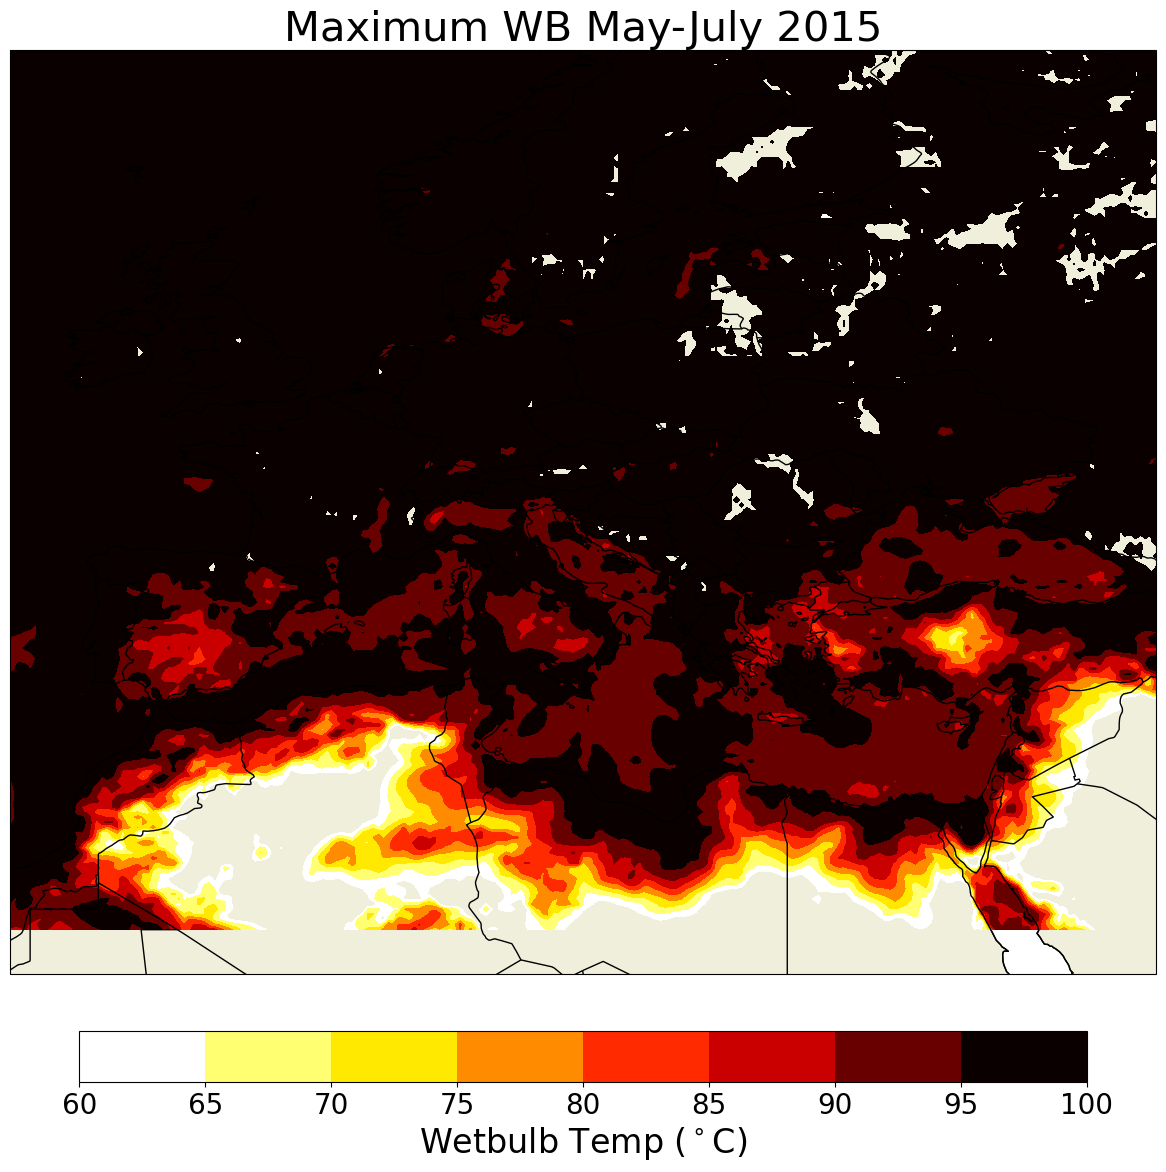

In [35]:
fig, ax = plt.subplots(figsize=(20, 15), subplot_kw={'projection': ccrs.PlateCarree()})
#ax.set_extent([-120, -85, 12, 35], crs=ccrs.PlateCarree())
cmap = plt.get_cmap('hot_r')

# Add coastlines and other features
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND, edgecolor='black')
#ax.add_feature(cfeature.OCEAN, zorder=100)


uneven_levels = np.arange(60,105,5)
colors = cmap(np.linspace(0, 1, len(uneven_levels) - 1))
cmap, norm = mcolors.from_levels_and_colors(uneven_levels, colors)
cmap.set_under("lightyellow")
cmap.set_under("black")
#cmap.set_over("maroon")

# Plot the data using contourf
contour = ax.contourf(lon,lat, WB_max,extent='both', transform=ccrs.PlateCarree(), cmap=cmap, levels=uneven_levels)

# Add a color bar
cbar = plt.colorbar(contour, ax=ax, orientation='horizontal', pad=0.05, shrink=0.65)
cbar.set_label('Wetbulb Temp ($^\circ$C)', fontsize=24)
cbar.ax.tick_params(labelsize=20)


# Add a title
ax.set_title('Maximum WB May-July 2015', fontsize=30)

# Show the plot
plt.show()






In [ ]:
for i, polygon in (enumerate(polygons[0:1])):
    ax.add_geometries([polygon], crs=ccrs.PlateCarree(), edgecolor='black',lw=3, facecolor='none')

lon1, lat1 = -110, 30
ax.plot(lon1, lat1, marker='o', color='limegreen', markersize=20, transform=ccrs.PlateCarree())
ax.text(lon1 + 0.5, lat1, 'Anconchi', transform=ccrs.PlateCarree(), fontsize=30, color='black')

lon1, lat1 = -100, 25
ax.plot(lon1, lat1, marker='o', color='limegreen', markersize=20, transform=ccrs.PlateCarree())
ax.text(lon1 + 0.5, lat1, 'Monterry', transform=ccrs.PlateCarree(),zorder=100, fontsize=30, color='black')

lon1, lat1 = -115, 32
ax.plot(lon1, lat1, marker='o', color='limegreen', markersize=20, transform=ccrs.PlateCarree())
ax.text(lon1 + 0.5, lat1, 'Mexicali', transform=ccrs.PlateCarree(),zorder=100, fontsize=30, color='black')



In [262]:
ds = xr.open_dataset('/g/data/rt52/era5/single-levels/reanalysis/sp/2015/sp_era5_oper_sfc_20150601-20150630.nc')
p1 = ds['sp'].sel(latitude=slice(34,4), longitude=slice(65,91))

In [263]:
ds2 = xr.open_dataset('/g/data/rt52/era5/single-levels/reanalysis/2d/2015/2d_era5_oper_sfc_20150601-20150630.nc')
Td1 = ds2['d2m'].sel(latitude=slice(34,4), longitude=slice(65,91))

In [264]:
ds3 = xr.open_dataset('/g/data/rt52/era5/single-levels/reanalysis/2t/2015/2t_era5_oper_sfc_20150601-20150630.nc')
T1 = ds3['t2m'].sel(latitude=slice(34,4), longitude=slice(65,91))

In [265]:
p = p1.resample(time='6h').mean()
Td = Td1.resample(time='6h').mean()
T = T1.resample(time='6h').mean()

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'


In [266]:
q = specific_humidity_from_dewpoint_temperature(p, Td)
RH = relative_humidity(p, T, q)

In [273]:
RH.to_netcdf("/home/581/cg8052/India_June_2023_RH_ERA5.nc")

In [268]:
ds = xr.Dataset({'p': p, 'T': T, 'q': q})
ds = ds.chunk(dict(latitude=-1))

In [269]:
wet_bulb_temp = apply_wet_bulb_temperature(ds)

In [270]:
WB_max2=np.nanmax(wet_bulb_temp, axis=0)
WB_max = WB_max2-273.15

In [271]:
lon = p1['longitude']
lat = p1['latitude']

In [288]:
gdf = geopandas.read_file("/home/581/cg8052/pak_adm_wfp_20220909_shp/pak_admbnda_adm1_wfp_20220909.shp")
#polygon_index = 5  # Choose the index of the polygon you want to use for clipping
#clip_polygon = gdf['geometry'][polygon_index]
#clip_polygon = Polygon(clip_polygon)
polygons = gdf.geometry

In [289]:
polygons

0    POLYGON ((74.46635 35.11060, 74.46940 35.11029...
1    MULTIPOLYGON (((63.86261 25.11428, 63.85069 25...
2    POLYGON ((74.75373 37.02594, 74.76399 37.02577...
3    POLYGON ((73.16415 33.81038, 73.16847 33.80451...
4    POLYGON ((73.66302 36.88825, 73.66858 36.88130...
5    MULTIPOLYGON (((69.55419 28.12376, 69.54910 28...
6    MULTIPOLYGON (((68.18577 23.83741, 68.19128 23...
Name: geometry, dtype: geometry

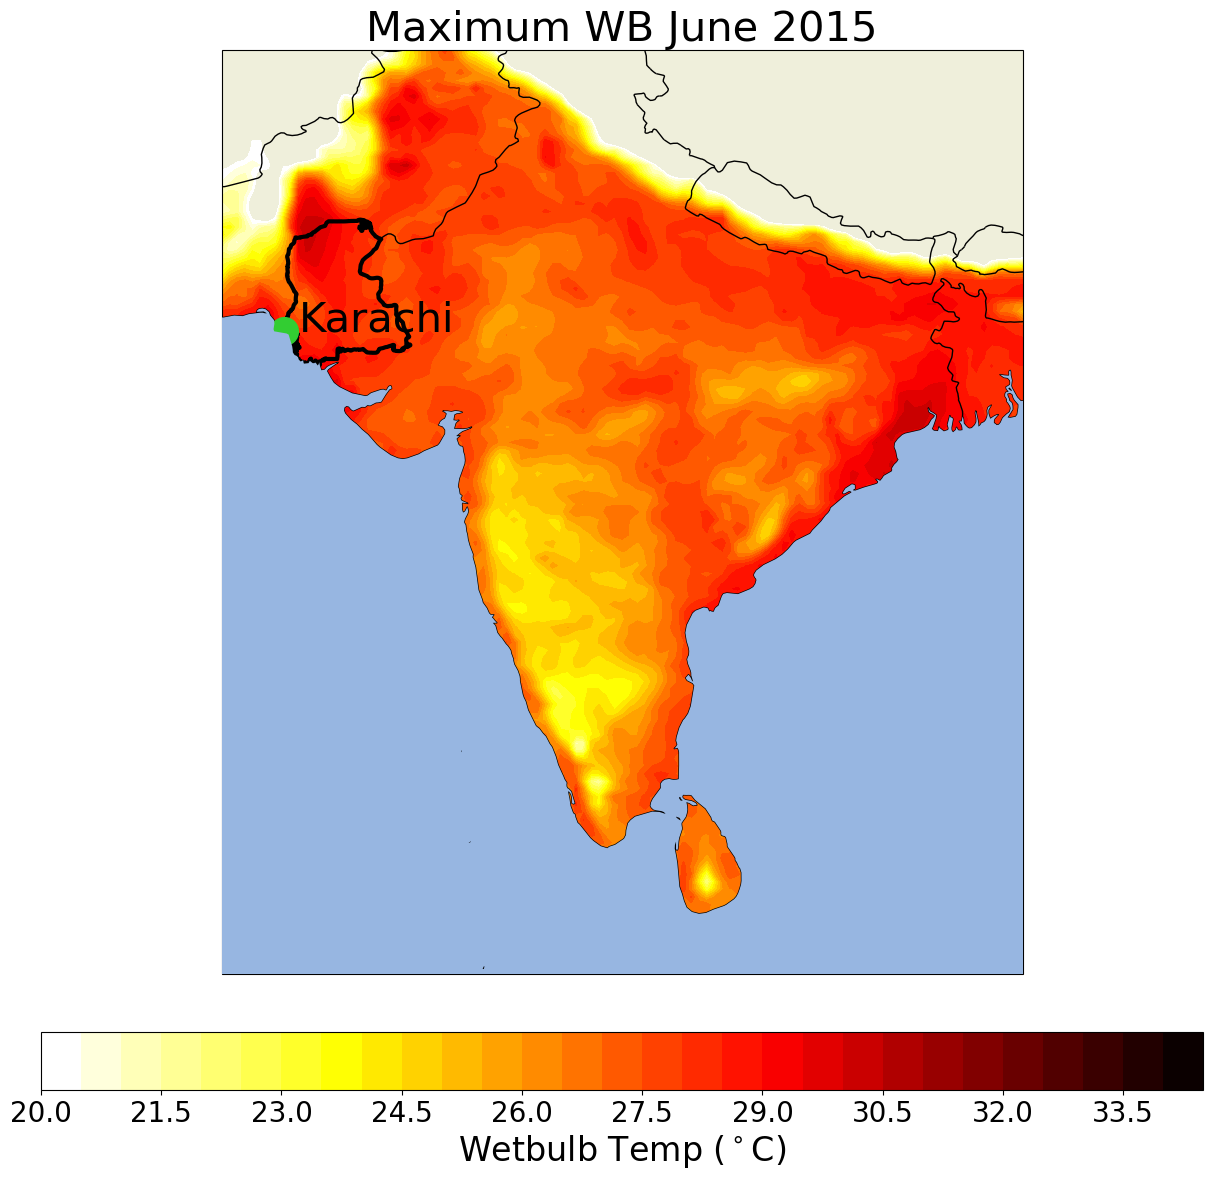

In [291]:
fig, ax = plt.subplots(figsize=(20, 15), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([65, 91, 4, 34], crs=ccrs.PlateCarree())
cmap = plt.get_cmap('hot_r')

# Add coastlines and other features
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN, zorder=100)


uneven_levels = np.arange(20,35,0.5)
colors = cmap(np.linspace(0, 1, len(uneven_levels) - 1))
cmap, norm = mcolors.from_levels_and_colors(uneven_levels, colors)
cmap.set_under("lightyellow")
cmap.set_under("black")
#cmap.set_over("maroon")

# Plot the data using contourf
contour = ax.contourf(lon,lat, WB_max,extent='both', transform=ccrs.PlateCarree(), cmap=cmap, levels=uneven_levels)

for i, polygon in (enumerate(polygons[6:7])):
    ax.add_geometries([polygon], crs=ccrs.PlateCarree(), edgecolor='black',lw=3, facecolor='none')
    
# Add a color bar
cbar = plt.colorbar(contour, ax=ax, orientation='horizontal', pad=0.05, shrink=0.75)
cbar.set_label('Wetbulb Temp ($^\circ$C)', fontsize=24)
cbar.ax.tick_params(labelsize=20)

lon1, lat1 = 67.01, 24.86
ax.plot(lon1, lat1, marker='o', color='limegreen', markersize=20, transform=ccrs.PlateCarree())
ax.text(lon1 + 0.5, lat1, 'Karachi', transform=ccrs.PlateCarree(),zorder=100, fontsize=30, color='black')

# Add a title
ax.set_title('Maximum WB June 2015', fontsize=30)

# Show the plot
plt.show()

In [11]:
sp_path_pattern = '/g/data/rt52/era5/single-levels/reanalysis/sp/{year}/sp_era5_oper_sfc_*.nc'

# Open the dataset for years 1979 to 2014
years = range(1979, 2015)
sp_datasets = [xr.open_mfdataset(sp_path_pattern.format(year=year), combine='by_coords') for year in years]

# Concatenate the datasets along the time dimension
sp_combined = xr.concat(sp_datasets, dim='time')
p1 = sp_combined.sel(latitude=slice(33, -12), longitude=slice(66, 132))

In [13]:

d2m_path_pattern = '/g/data/rt52/era5/single-levels/reanalysis/2d/{year}/2d_era5_oper_sfc_*.nc'

# Open the dataset for years 1979 to 2014
d2m_datasets = [xr.open_mfdataset(d2m_path_pattern.format(year=year), combine='by_coords') for year in years]

# Concatenate the datasets along the time dimension
d2m_combined = xr.concat(d2m_datasets, dim='time')
Td1 = d2m_combined.sel(latitude=slice(33, -12), longitude=slice(66, 132))


In [14]:

t2m_path_pattern = '/g/data/rt52/era5/single-levels/reanalysis/2t/{year}/2t_era5_oper_sfc_*.nc'

# Open the dataset for years 1979 to 2014
t2m_datasets = [xr.open_mfdataset(t2m_path_pattern.format(year=year), combine='by_coords') for year in years]

# Concatenate the datasets along the time dimension
t2m_combined = xr.concat(t2m_datasets, dim='time')
T1 = t2m_combined.sel(latitude=slice(33, -12), longitude=slice(66, 132))


In [15]:
p = p1.resample(time='6h').mean()
Td = Td1.resample(time='6h').mean()
T = T1.resample(time='6h').mean()

In [16]:
def specific_humidity_from_dewpoint_temperature(p, Td):
    """
    Computes specific humidity from pressure and dewpoint temperature.

    Args:
        p (float or ndarray): pressure (Pa)
        Td (float or ndarray): dewpoint temperature (K)

    Returns:
        q (float or ndarray): specific humidity (kg/kg)

    """    
    q = saturation_specific_humidity(p, Td, phase='liquid')

    return q

In [17]:
q = specific_humidity_from_dewpoint_temperature(p, Td)

In [18]:
RH = relative_humidity(p, T, q)

In [19]:
RH

<xarray.Dataset> Size: 423kB
Dimensions:    (longitude: 265, latitude: 181, time: 52596)
Coordinates:
  * longitude  (longitude) float32 1kB 66.0 66.25 66.5 ... 131.5 131.8 132.0
  * latitude   (latitude) float32 724B 33.0 32.75 32.5 ... -11.5 -11.75 -12.0
  * time       (time) datetime64[ns] 421kB 1979-01-01 ... 2014-12-31T18:00:00
Data variables:
    *empty*

In [22]:
DS = xr.open_dataset('/g/data/oi10/replicas/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r1i1p1f1/6hrPlev/tas/gn/v20190815/tas_6hrPlev_MPI-ESM1-2-HR_historical_r1i1p1f1_gn_185001010300-185412312100.nc')
tas = DS['tas'].sel(lat=slice(-12, 33), lon=slice(66, 132))
tas

<xarray.DataArray 'tas' (time: 7304, lat: 48, lon: 70)> Size: 98MB
[24541440 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 58kB 1850-01-01T03:00:00 ... 1854-12-31T21...
  * lat      (lat) float64 384B -11.69 -10.75 -9.818 ... 30.39 31.32 32.26
  * lon      (lon) float64 560B 66.56 67.5 68.44 69.38 ... 129.4 130.3 131.2
    height   float64 8B ...
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    comment:        near-surface (usually, 2 meter) air temperature
    units:          K
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2020-03-27T11:24:36Z altered by CMOR: Treated scalar dime...